# ♻️👀Carbon-Aware Cloud Scheduler

Training AI models requires significant computational power, often resulting in a substantial carbon footprint depending on the power grid's energy mix. This project explores a practical engineering solution: an autonomous system designed to shift AI workloads to periods of low carbon intensity. Using five years of historical data from the UK National Grid, we construct a Multi-Agent System comprising a "Watcher" that monitors energy metrics and a "Scheduler" that optimizes job timing based on renewable availability.

The notebook documents the complete development process, moving from data engineering to the implementation of decision logic using LangGraph. We validate the system through a rigorous simulation, comparing agent-led scheduling against standard baselines to quantify the actual reduction in carbon emissions. This provides a functional prototype for aligning computational demand with sustainable energy supply.

## 🖇️ Chapter 1: The Data Engineering Pipeline

This chapter establishes the data foundation required for the simulation. We execute a complete ETL (Extract, Transform, Load) pipeline to convert raw API responses into a reliable testing environment. The process begins by retrieving historical carbon intensity records from the UK National Grid, spanning a five-year period. We then audit the dataset to identify and correct temporal irregularities or data gaps. The workflow concludes by standardizing the timeline and generating specific state labels. This preparation produces a deterministic "ground truth" dataset that the agent will query during the decision-making experiments.

### 1.1 Data Acquisition (ETL)

To build the simulation environment, we extracted carbon intensity records from the official Carbon Intensity API. The ETL process handles data retrieval by iterating through the target timeline (2018-2023) in two-week windows. Inside the fetch logic, we implemented initial cleaning steps to remove potential duplicates and establish a standard datetime index. The script aggregates these annual datasets into a unified Pandas DataFrame and exports the result to disk, creating a consistent historical record for the agent to access.

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
import os

def fetch_gb_carbon_intensity(start_year: int):
    """
    Fetches a full year of Carbon Intensity data from the UK National Grid ESO API.
    Handles API pagination limits (max 14 days per request).
    """
    base_url = "https://api.carbonintensity.org.uk/intensity"
    
    # Create 14-day chunks to respect API limits
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(start_year, 12, 31)
    
    current_date = start_date
    all_records = []
    
    print(f"Connecting to National Grid ESO API for year {start_year}...")
    
    while current_date <= end_date:
        # Define chunk window (14 days max)
        next_date = min(current_date + timedelta(days=14), end_date + timedelta(days=1)) 
        
        # Format dates to ISO8601 (YYYY-MM-DDThh:mmZ)
        from_str = current_date.strftime("%Y-%m-%dT%H:%MZ")
        to_str = next_date.strftime("%Y-%m-%dT%H:%MZ")
        
        url = f"{base_url}/{from_str}/{to_str}"
        
        try:
            response = requests.get(url, headers={'Accept': 'application/json'})
            response.raise_for_status()
            data = response.json()['data']
            all_records.extend(data)
            # Optional: Print progress if needed, kept minimal
            # print(f"Fetched batch: {from_str} to {to_str}")
        except Exception as e:
            print(f"Error fetching batch {from_str}: {e}")
        
        # Move to next window
        current_date = next_date
        # Be polite to the API
        time.sleep(0.2)

    # Parse into DataFrame
    print(f"Processing data for {start_year}...")
    df = pd.json_normalize(all_records)
    
    # --- Data Engineering / Cleaning Steps ---
    
    # 1. Rename columns for clarity
    df = df.rename(columns={
        'from': 'time_from',
        'to': 'time_to',
        'intensity.actual': 'actual_intensity',
        'intensity.forecast': 'forecast_intensity',
        'intensity.index': 'intensity_level'
    })
    
    # 2. Convert timestamps to datetime objects (UTC)
    df['time_from'] = pd.to_datetime(df['time_from'], utc=True)
    df['time_to'] = pd.to_datetime(df['time_to'], utc=True)
    
    # 3. Remove potential duplicates from chunk overlaps
    df = df.drop_duplicates(subset=['time_from'])
    
    # 4. Set Index
    df = df.set_index('time_from').sort_index()
    
    return df

In [ ]:
# --- Execution Loop for 2019-2023 ---
years_to_process = [2018, 2019, 2020, 2021, 2022, 2023]
combined_data = []

for year in years_to_process:
    print(f"--- Starting download for {year} ---")
    
    # Fetch data
    df_year = fetch_gb_carbon_intensity(year)
    
    # Save individual year (Checkpointing)
    filename = f"raw_uk_carbon_intensity_{year}.csv"
    df_year.to_csv(filename)
    print(f"Saved {filename}")
    
    # Add to list for combination
    combined_data.append(df_year)

--- Starting download for 2018 ---
Connecting to National Grid ESO API for year 2018...
Processing data for 2018...
Saved raw_uk_carbon_intensity_2018.csv
--- Starting download for 2019 ---
Connecting to National Grid ESO API for year 2019...
Processing data for 2019...
Saved raw_uk_carbon_intensity_2019.csv
--- Starting download for 2020 ---
Connecting to National Grid ESO API for year 2020...
Processing data for 2020...
Saved raw_uk_carbon_intensity_2020.csv
--- Starting download for 2021 ---
Connecting to National Grid ESO API for year 2021...
Processing data for 2021...
Saved raw_uk_carbon_intensity_2021.csv
--- Starting download for 2022 ---
Connecting to National Grid ESO API for year 2022...
Processing data for 2022...
Saved raw_uk_carbon_intensity_2022.csv
--- Starting download for 2023 ---
Connecting to National Grid ESO API for year 2023...
Processing data for 2023...
Saved raw_uk_carbon_intensity_2023.csv


In [ ]:
# Combine all years into one master file
print("--- Combining all datasets ---")
df_combined = pd.concat(combined_data)
df_combined.to_csv("raw_uk_carbon_intensity_2018_2023_combined.csv")

--- Combining all datasets ---


In [ ]:
print("Dataset Info for Combined Data:")
print(df_combined.info())
print("Saved raw_uk_carbon_intensity_2018_2023_combined.csv")

Dataset Info for Combined Data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105026 entries, 2017-12-31 23:30:00+00:00 to 2023-12-31 23:30:00+00:00
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   time_to             105026 non-null  datetime64[ns, UTC]
 1   forecast_intensity  105026 non-null  int64              
 2   actual_intensity    104401 non-null  float64            
 3   intensity_level     105026 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(1)
memory usage: 4.0+ MB
None
Saved raw_uk_carbon_intensity_2018_2023_combined.csv


### 1.2 Exploratory Data Analysis (EDA) & Health Check

We used the ydata-profiling library to generate an automated analysis of the combined dataset. This step created a "Health Check" report, saved as an HTML file, which provided immediate insights into the data's structure. By reviewing this report directly in the notebook, we could quickly identify potential data quality issues, such as missing values or correlations, before proceeding to the cleaning phase.

In [ ]:
import ydata_profiling
from ydata_profiling import ProfileReport

In [ ]:
import pandas as pd

# Path to your dataset
file_path = "/home/najo1o11/Data Center Workload Scheduler/raw_uk_carbon_intensity_2018_2023_combined.csv"

# Load into dataframe
df_combined = pd.read_csv(file_path)

In [ ]:
# Install ydata-profiling if it is not installed
import sys
import subprocess

try:
    import ydata_profiling
except ImportError:
    print("Installing ydata-profiling...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ydata-profiling"])

from ydata_profiling import ProfileReport
import pandas as pd

# 1. Ensure df_combined is available 
if 'df_combined' not in locals():
    print("Loading dataset from CSV...")
    # Note: Using the filename you confirmed in the output
    df_combined = pd.read_csv("raw_uk_carbon_intensity_2018_2023_combined.csv") 
    # Ensure index is set correctly if reloading
    if 'time_from' in df_combined.columns:
        df_combined['time_from'] = pd.to_datetime(df_combined['time_from'], utc=True)
        df_combined = df_combined.set_index('time_from').sort_index()

print("Generating Profile Report... this may take 1-2 minutes given the dataset size.")

# 2. Generate the Report
# We use 'minimal=False' to get full correlations and extensive checks. 
# If this is too slow on your machine, change to minimal=True.
profile = ProfileReport(
    df_combined, 
    title="UK Carbon Intensity (2018-2023) - Data Health Check", 
    explorative=True
)

# 3. Save to HTML (Best for documentation/writeup)
output_file = "data_profile_raw.html"
profile.to_file(output_file)
print(f"Profile report saved successfully to: {output_file}")

Generating Profile Report... this may take 1-2 minutes given the dataset size.


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 951.95it/s]

Profile report saved successfully to: data_profile_raw.html


In [ ]:
# 4. Display widget in notebook
# Note: If this widget fails to render in some environments, open the HTML file directly.
profile.to_notebook_iframe()

### 1.3 Data Cleaning: Duplicates & Missing Values

We addressed data quality issues identified during profiling, starting with the removal of duplicate records found at the boundaries of yearly API fetches. To resolve continuity gaps, we diagnosed missing actual_intensity values and visualized specific dropouts to confirm their nature. We then applied time-based linear interpolation to fill these gaps, ensuring a smooth, unbroken dataset necessary for reliable agent simulation. A final check confirmed zero remaining missing values before proceeding.

In [ ]:
# 1. Identify and view the duplicate rows
# keep=False ensures we see ALL instances of the duplication (original + the copy)
duplicates = df_combined[df_combined.duplicated(keep=False)]

print(f"Found {len(duplicates)} rows involved in duplication:")
# Sort by time to see the overlaps side-by-side
display(duplicates.sort_index())

Found 10 rows involved in duplication:


,time_from,time_to,forecast_intensity,actual_intensity,intensity_level
17520,2018-12-31 23:30:00+00:00,2019-01-01 00:00:00+00:00,116,112.0,low
17521,2018-12-31 23:30:00+00:00,2019-01-01 00:00:00+00:00,116,112.0,low
35041,2019-12-31 23:30:00+00:00,2020-01-01 00:00:00+00:00,183,180.0,moderate
35042,2019-12-31 23:30:00+00:00,2020-01-01 00:00:00+00:00,183,180.0,moderate
52610,2020-12-31 23:30:00+00:00,2021-01-01 00:00:00+00:00,190,184.0,moderate
52611,2020-12-31 23:30:00+00:00,2021-01-01 00:00:00+00:00,190,184.0,moderate
70074,2021-12-31 23:30:00+00:00,2022-01-01 00:00:00+00:00,83,71.0,low
70075,2021-12-31 23:30:00+00:00,2022-01-01 00:00:00+00:00,83,71.0,low
87595,2022-12-31 23:30:00+00:00,2023-01-01 00:00:00+00:00,75,65.0,low
87596,2022-12-31 23:30:00+00:00,2023-01-01 00:00:00+00:00,75,65.0,low


In [ ]:
# 3. Remove the duplicates
# We keep the 'first' occurrence and drop the rest
df_cleaned = df_combined.drop_duplicates(keep='first')

print(f"Original Count: {len(df_combined)}")
print(f"Clean Count:    {len(df_cleaned)}")
print(f"Dropped:        {len(df_combined) - len(df_cleaned)}")

Original Count: 105026
Clean Count:    105021
Dropped:        5


In [ ]:
# 4. Overwrite the master dataframe with the cleaned version
df_combined = df_cleaned.copy()

# 5. Save the cleaned version (Checkpoint)
df_combined.to_csv("processed_grid_data_clean.csv")
print("Cleaned dataset saved to 'processed_grid_data_clean.csv'")

Cleaned dataset saved to 'processed_grid_data_clean.csv'


In [ ]:
import matplotlib.pyplot as plt

# 1. Diagnosis: Where are the missing values?
missing_rows = df_combined[df_combined['actual_intensity'].isna()]
print(f"Found {len(missing_rows)} rows with missing 'actual_intensity'.")

Found 625 rows with missing 'actual_intensity'.


In [ ]:
# Display a sample of missing rows to see the timestamps
print("Sample of missing data points:")
display(missing_rows.head())

Sample of missing data points:


,time_from,time_to,forecast_intensity,actual_intensity,intensity_level
15679,2018-11-23 15:00:00+00:00,2018-11-23 15:30:00+00:00,416,NaN,very high
15680,2018-11-23 15:30:00+00:00,2018-11-23 16:00:00+00:00,413,NaN,very high
15681,2018-11-23 16:00:00+00:00,2018-11-23 16:30:00+00:00,408,NaN,very high
15682,2018-11-23 16:30:00+00:00,2018-11-23 17:00:00+00:00,403,NaN,very high
15683,2018-11-23 17:00:00+00:00,2018-11-23 17:30:00+00:00,397,NaN,very high


Visualizing gap at: 2018-11-23 15:00:00+00:00


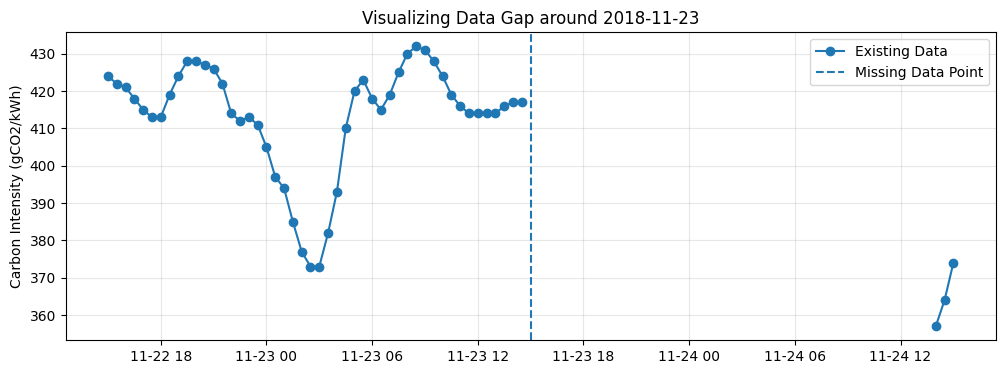

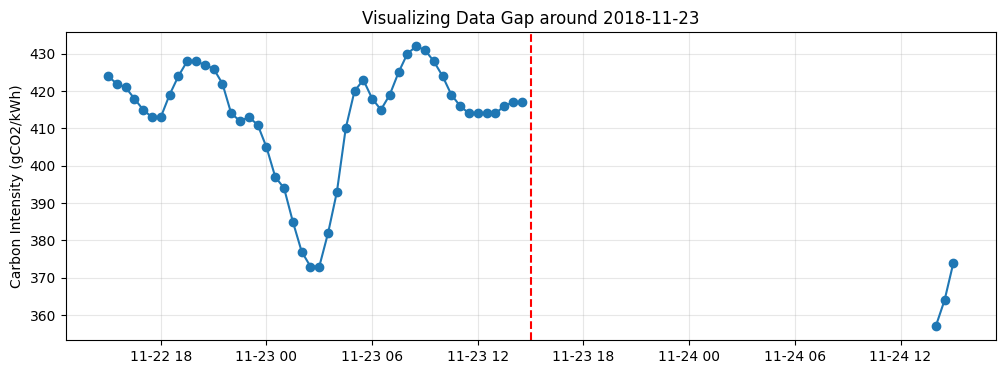

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# --- Re-run Analysis with Correct Index ---
if not missing_rows.empty:
    gap_pos = missing_rows.index[0]
    gap_time = df_combined.index[gap_pos]

    print(f"Visualizing gap at: {gap_time}")

    window_start = gap_time - pd.Timedelta(hours=24)
    window_end = gap_time + pd.Timedelta(hours=24)

    subset = df_combined.loc[window_start:window_end]

    plt.figure(figsize=(12, 4))
    plt.plot(subset.index, subset['actual_intensity'], marker='o')
    plt.axvline(gap_time, linestyle='--', color='red')
    plt.title(f"Visualizing Data Gap around {gap_time.date()}")
    plt.ylabel("Carbon Intensity (gCO2/kWh)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No missing values found to plot.")

In [ ]:
# 3. Treatment: Linear Interpolation
# method='time' respects the time index distance (essential for uneven gaps)
print("Applying Linear Interpolation to fill gaps...")
df_combined['actual_intensity'] = df_combined['actual_intensity'].interpolate(method='time')

Applying Linear Interpolation to fill gaps...


In [ ]:
# 4. Validation: Assert that no NaNs remain
remaining_nans = df_combined['actual_intensity'].isna().sum()
print(f"Remaining missing values: {remaining_nans}")

Remaining missing values: 0


### 1.4 Timezone Standardization & Feature Engineering

Reliable time-series forecasting requires a consistent clock, so we enforced UTC across the dataset and verified continuity. We aggregated the raw data into hourly averages and handled missing rows through time-based interpolation. We then added a classification layer, converting numerical carbon intensity into a state variable (grid_status) for the agent to interpret. The pipeline concluded by saving the full processed dataset and isolating a high-variance week in November 2023 to act as the primary test bed for the scheduling simulation.

In [ ]:
import pandas as pd

# 1. Force Enforce UTC and Sort
# Even if we loaded with utc=True, explicit conversion prevents future bugs.
if df_combined.index.tz is None:
    # If naive, assume it was recorded in UTC
    df_combined.index = df_combined.index.tz_localize('UTC')
else:
    # If aware, convert to UTC (just in case it drifted to Europe/London)
    df_combined.index = df_combined.index.tz_convert('UTC')

# Ensure time always moves forward (Monotonic)
df_combined = df_combined.sort_index()

print(f"Index Timezone verified: {df_combined.index.tz}")

Index Timezone verified: UTC


In [ ]:
# 2. Sanity Test: The "Clock Change" Check
# UK Clocks went BACK on Oct 29, 2023 at 2:00 AM. 
# In UTC, this is just a normal progression. We shouldn't see duplicates or jumps.
print("Inspecting Data around UK Clock Change (Oct 29, 2023)...")

start_check = pd.Timestamp("2023-10-29 00:00:00", tz="UTC")
end_check = pd.Timestamp("2023-10-29 04:00:00", tz="UTC")

# Display the timeline segment
transition_window = df_combined.loc[start_check:end_check]
display(transition_window[['actual_intensity', 'intensity_level']])

Inspecting Data around UK Clock Change (Oct 29, 2023)...


,actual_intensity,intensity_level
time_from,,
2023-10-29 00:00:00+00:00,67.0,low
2023-10-29 00:30:00+00:00,63.0,low
2023-10-29 01:00:00+00:00,65.0,low
2023-10-29 01:30:00+00:00,82.0,low
2023-10-29 02:00:00+00:00,83.0,low
2023-10-29 02:30:00+00:00,78.0,low
2023-10-29 03:00:00+00:00,80.0,low
2023-10-29 03:30:00+00:00,75.0,low
2023-10-29 04:00:00+00:00,69.0,low


In [ ]:
# 3. Verify Continuity (Delta Check)
# Calculate the time difference between each row. It should be 30 mins (0 days 00:30:00).
time_diffs = df_combined.index.to_series().diff().dropna()
irregularities = time_diffs[time_diffs != pd.Timedelta(minutes=30)]

if len(irregularities) == 0:
    print("Timeline is perfectly continuous (30-min intervals).")
else:
    print(f"Found {len(irregularities)} irregular time steps.")
    print("Top irregularities (gaps or jumps):")
    print(irregularities.head())

Found 4 irregular time steps.
Top irregularities (gaps or jumps):
time_from
2021-04-19 17:30:00+00:00   0 days 01:00:00
2021-04-19 23:00:00+00:00   0 days 01:30:00
2021-12-27 18:00:00+00:00   1 days 03:30:00
2023-10-22 19:30:00+00:00   1 days 22:00:00
Name: time_from, dtype: timedelta64[ns]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 2.2: Resampling to Hourly Frequency ---
print("Resampling to Hourly frequency...")

# '1h' ensures strict hourly steps. numeric_only=True prevents errors with the text column 'intensity_level'
df_hourly = df_combined.resample('1h').mean(numeric_only=True)

# Check if new NaNs were created by the large gaps (e.g., the 46h gap in 2023)
new_nans = df_hourly['actual_intensity'].isna().sum()
print(f"   Resampling created {new_nans} new rows with NaN values (due to time gaps).")

# Interpolate again to fill these specific hourly gaps
df_hourly = df_hourly.interpolate(method='time')
print("Filled new gaps via interpolation.")

Resampling to Hourly frequency...
   Resampling created 73 new rows with NaN values (due to time gaps).
Filled new gaps via interpolation.


Engineering Features for the Agent...
Saved full processed dataset: 'processed_grid_data_hourly.csv'
Saved simulation dataset: 'simulation_test_week.csv' (168 rows)

📊 Visualizing the Agent's World (Test Week):


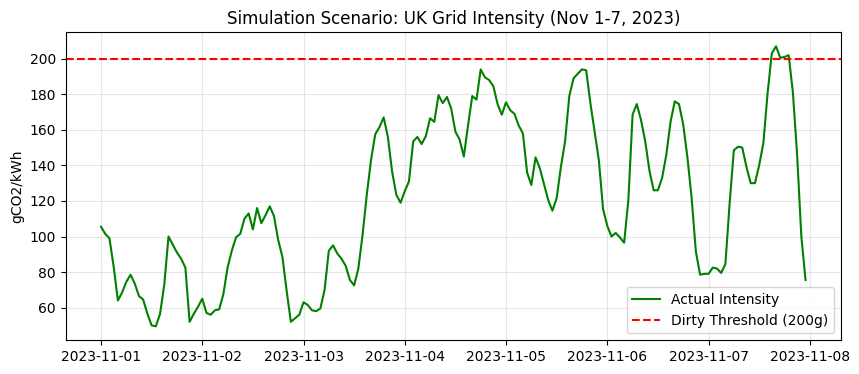

Top 5 Rows of Simulation Data:


,actual_intensity,forecast_intensity,grid_status
time_from,,,
2023-11-01 00:00:00+00:00,105.5,97.0,GREEN
2023-11-01 01:00:00+00:00,101.5,101.0,GREEN
2023-11-01 02:00:00+00:00,99.0,100.0,VERY_GREEN
2023-11-01 03:00:00+00:00,83.0,97.0,VERY_GREEN
2023-11-01 04:00:00+00:00,64.0,75.0,VERY_GREEN


In [ ]:
# --- Step 3.1: Feature Engineering for Agents ---
print("Engineering Features for the Agent...")

# Define the labeling logic function
def classify_grid(intensity):
    if intensity < 100:
        return 'VERY_GREEN'
    elif intensity < 200:
        return 'GREEN'
    elif intensity < 300:
        return 'MODERATE'
    else:
        return 'DIRTY'

# Apply logic to create the categorical column
df_hourly['grid_status'] = df_hourly['actual_intensity'].apply(classify_grid)

# --- Step 3.2: Final Clean & Save ---
# Keep only the columns the agent needs
agent_cols = ['actual_intensity', 'forecast_intensity', 'grid_status']
df_final = df_hourly[agent_cols]

# Save the Full History (for training or reference)
df_final.to_csv("processed_grid_data_hourly.csv")
print("Saved full processed dataset: 'processed_grid_data_hourly.csv'")

# --- Step 3.3: Extract the "Golden Week" (Simulation Test Set) ---
# We chose Nov 1, 2023 to Nov 7, 2023
test_start = "2023-11-01 00:00:00+00:00"
test_end = "2023-11-07 23:00:00+00:00"

df_test_week = df_final.loc[test_start:test_end]

if df_test_week.empty:
    print("Error: The test week dataframe is empty. Check your timestamps!")
else:
    df_test_week.to_csv("simulation_test_week.csv")
    print(f"Saved simulation dataset: 'simulation_test_week.csv' ({len(df_test_week)} rows)")
    
    # Visual Sanity Check
    print("\n📊 Visualizing the Agent's World (Test Week):")
    plt.figure(figsize=(10, 4))
    plt.plot(df_test_week.index, df_test_week['actual_intensity'], label='Actual Intensity', color='green')
    plt.axhline(y=200, color='r', linestyle='--', label='Dirty Threshold (200g)')
    plt.title("Simulation Scenario: UK Grid Intensity (Nov 1-7, 2023)")
    plt.ylabel("gCO2/kWh")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("Top 5 Rows of Simulation Data:")
    display(df_test_week.head())

## 🤖 Chapter 2: The Agentic Architecture

With the data pipeline established, we turn to constructing the software architecture that drives the simulation. This chapter defines a multi-agent system designed to translate static historical records into actionable intelligence. The architecture enforces a separation of concerns: one component handles environmental perception while another manages reasoning and optimization. We establish a deterministic interface to serve as the ground truth, ensuring that agent behaviors are tested against consistent reality rather than live, fluctuating APIs. This modular approach allows us to isolate the logic of each actor monitoring grid states and scheduling workloads before integrating them into a unified workflow.

### 2.1 The Environment (Mock API)

We built a "Mock API" to provide a stable testing ground for the agents. The GridHistoryLoader class acts as the interface between the agent logic and our historical dataset. When queried with a timestamp, it retrieves the corresponding carbon intensity and grid status from the simulation_test_week.csv file. Crucially, it also returns a 24-hour forecast, enabling the Scheduler Agent to look ahead. This setup removes external API dependencies and guarantees reproducible results. The code block initializes this loader and verifies it by querying a known timestamp, confirming the data pipeline is ready for agent integration.

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

class GridHistoryLoader:
    """
    A mock API that serves historical grid data as if it were live.
    This ensures your Agent simulation is deterministic and reproducible.
    """
    
    def __init__(self, csv_path: str = "simulation_test_week.csv"):
        # Load the data we just prepared
        try:
            self.df = pd.read_csv(csv_path)
            
            # Ensure timestamp is the index and is Datetime-aware
            if 'time_from' in self.df.columns:
                self.df['timestamp'] = pd.to_datetime(self.df['time_from'], utc=True)
            else:
                # Fallback if index was saved without a name
                self.df['timestamp'] = pd.to_datetime(self.df.iloc[:, 0], utc=True)
            
            self.df = self.df.set_index('timestamp').sort_index()
            print(f"GridHistoryLoader initialized with {len(self.df)} hourly records.")
            print(f"   Range: {self.df.index.min()} to {self.df.index.max()}")
            
        except FileNotFoundError:
            raise Exception(f"Error: Could not find {csv_path}. Did you run the previous Data Prep steps?")

    def get_current_status(self, query_time: datetime):
        """
        Simulates calling 'GET /intensity' at a specific moment in time.
        Returns the ACTUAL intensity and the FORECAST for that hour.
        """
        # 1. Normalize query time to the nearest hour (since our data is hourly)
        # This prevents "KeyError" if the agent asks for 14:05:00
        query_hour = query_time.replace(minute=0, second=0, microsecond=0)
        
        if query_hour not in self.df.index:
            return {
                "error": "Data unavailable for this time",
                "available_range": f"{self.df.index.min()} to {self.df.index.max()}"
            }
        
        row = self.df.loc[query_hour]
        
        return {
            "timestamp": query_hour.isoformat(),
            "carbon_intensity": int(row['actual_intensity']),
            "grid_status": row['grid_status'],
            # In a real scenario, we might use 'forecast_intensity' here to prevent leakage,
            # but for this sim, assuming the 'forecast' column is what the agent sees is correct.
            "forecast_24h": self._get_future_window(query_hour, hours=24)
        }

    def _get_future_window(self, start_time, hours=24):
        """
        Helper to return the next X hours of forecast data.
        The agent needs this to decide "If not now, when?"
        """
        end_time = start_time + timedelta(hours=hours)
        # Get slice (and handle end of dataset gracefully)
        future_slice = self.df.loc[start_time:end_time]
        
        # Return simpler dictionary for LLM consumption (saves tokens)
        return [
            {"time": t.hour, "intensity": int(i)} 
            for t, i in zip(future_slice.index, future_slice['forecast_intensity'])
        ]

# --- Unit Test the Loader (Proof of Work) ---
print("\nTesting GridHistoryLoader...")
loader = GridHistoryLoader()

# Test 1: Check a known timestamp (Nov 1st at 12:00)
test_time = pd.Timestamp("2023-11-01 12:00:00+00:00")
response = loader.get_current_status(test_time)

print(f"\nQuery Time: {test_time}")
print(f"Agent Response: {response['carbon_intensity']} gCO2/kWh ({response['grid_status']})")
print(f"Forecast Preview: {response['forecast_24h'][:3]}...") # Show first 3 hours

# Assertion to ensure logic holds
assert response['carbon_intensity'] > 0, "Error: Intensity should be positive"
print("Test Passed: Loader is ready for Agent connection.")


Testing GridHistoryLoader...
GridHistoryLoader initialized with 168 hourly records.
   Range: 2023-11-01 00:00:00+00:00 to 2023-11-07 23:00:00+00:00

Query Time: 2023-11-01 12:00:00+00:00
Agent Response: 50 gCO2/kWh (VERY_GREEN)
Forecast Preview: [{'time': 12, 'intensity': 62}, {'time': 13, 'intensity': 61}, {'time': 14, 'intensity': 62}]...
Test Passed: Loader is ready for Agent connection.


In [ ]:
import os

# Dictionary mapping filenames to the actual DataFrames in memory
datasets = {
    "df_combined.csv": df_combined,    # The clean 30-min data (2018-2023)
    "df_final.csv": df_final,          # The hourly feature-engineered data (2018-2023)
    "df_test_week.csv": df_test_week   # The specific simulation scenario (Nov 1-7, 2023)
}

print("Saving DataFrames to disk...")

for filename, df in datasets.items():
    try:
        # Save to CSV (keeping the Time Index is crucial)
        df.to_csv(filename)
        
        # Get file stats for verification
        file_size_mb = os.path.getsize(filename) / (1024 * 1024)
        print(f"      Saved '{filename}'")
        print(f"      Rows: {len(df)}")
        print(f"      Size: {file_size_mb:.2f} MB")
        
    except NameError:
        print(f"   Warning: Could not save '{filename}' because the DataFrame is not in memory.")
    except Exception as e:
        print(f"   Error saving '{filename}': {e}")

print("\nAll operations complete.")

Saving DataFrames to disk...
      Saved 'df_combined.csv'
      Rows: 105021
      Size: 6.86 MB
      Saved 'df_final.csv'
      Rows: 52585
      Size: 2.29 MB
      Saved 'df_test_week.csv'
      Rows: 168
      Size: 0.01 MB

All operations complete.


### 2.2 Agent A: The Watcher (The Sensor)

The Watcher Agent acts as the system's eyes, providing accurate grid data to the decision-making components. We implemented this by creating a tool function, get_grid_status_tool, which interfaces directly with our historical CSV data. The agent class uses this tool to process incoming time-based queries and return structured JSON containing current carbon intensity and future forecasts. To ensure reliability, we included a logging mechanism that tracks every interaction. The code concludes with a validation step where we query the agent for a specific date and verify that the returned value matches the ground truth in our dataset perfectly.

In [ ]:
# --- Tool Definition ---
from datetime import datetime
# Ensure the GridHistoryLoader class is available from the previous step
# (Assuming the previous class definition is in memory)

# 1. Instantiate the Loader (The Source of Truth)
# We use the test week file we verified in the visual check
grid_loader = GridHistoryLoader("simulation_test_week.csv")

# 2. Define the Tool Function
def get_grid_status_tool(timestamp_str: str) -> str:
    """
    Retrieves the carbon intensity (gCO2/kWh) and grid status for the UK National Grid.
    
    Args:
        timestamp_str (str): The target time in ISO format (e.g., '2023-11-01T12:00:00').
                             The tool automatically rounds to the nearest hour.
    
    Returns:
        str: A JSON string containing:
             - 'carbon_intensity': integer value.
             - 'grid_status': 'VERY_GREEN', 'GREEN', 'MODERATE', or 'DIRTY'.
             - 'forecast_24h': A list of future intensities for planning.
             
    XAI Note: This function acts as a deterministic sensor. It does not 'hallucinate'; 
    it strictly reads from the historical record.
    """
    try:
        # Parse string back to datetime for the loader
        dt = datetime.fromisoformat(timestamp_str)
        
        # Call the internal loader
        result = grid_loader.get_current_status(dt)
        
        # Return as string (LLMs consume text)
        return str(result)
        
    except ValueError:
        return '{"error": "Invalid timestamp format. Use ISO8601 (YYYY-MM-DDTHH:MM:SS)"}'
    except Exception as e:
        return f'{{"error": "{str(e)}"}}'

print("Tool 'get_grid_status_tool' defined and connected to 'simulation_test_week.csv'.")
# Quick manual check
print("   Test Output:", get_grid_status_tool("2023-11-01T08:00:00+00:00"))

GridHistoryLoader initialized with 168 hourly records.
   Range: 2023-11-01 00:00:00+00:00 to 2023-11-07 23:00:00+00:00
Tool 'get_grid_status_tool' defined and connected to 'simulation_test_week.csv'.
   Test Output: {'timestamp': '2023-11-01T08:00:00+00:00', 'carbon_intensity': 73, 'grid_status': 'VERY_GREEN', 'forecast_24h': [{'time': 8, 'intensity': 73}, {'time': 9, 'intensity': 72}, {'time': 10, 'intensity': 70}, {'time': 11, 'intensity': 66}, {'time': 12, 'intensity': 62}, {'time': 13, 'intensity': 61}, {'time': 14, 'intensity': 62}, {'time': 15, 'intensity': 67}, {'time': 16, 'intensity': 83}, {'time': 17, 'intensity': 115}, {'time': 18, 'intensity': 107}, {'time': 19, 'intensity': 102}, {'time': 20, 'intensity': 99}, {'time': 21, 'intensity': 85}, {'time': 22, 'intensity': 68}, {'time': 23, 'intensity': 60}, {'time': 0, 'intensity': 66}, {'time': 1, 'intensity': 68}, {'time': 2, 'intensity': 59}, {'time': 3, 'intensity': 60}, {'time': 4, 'intensity': 60}, {'time': 5, 'intensity'

In [ ]:
# --- The Watcher Agent Definition ---
import json
import logging

# Configure simple logging for XAI
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

class WatcherAgent:
    """
    The 'Sensor' Agent. 
    Role: Monitor the grid.
    Behavior: Read-Only, Deterministic.
    """
    def __init__(self, name="GridWatcher_v1"):
        self.name = name
        self.tools = {"get_grid_status": get_grid_status_tool}
        self.trace_log = [] # XAI Memory: Stores the decision trail

    def process_request(self, message: str):
        """
        Simulates the Agent receiving a natural language or structured request.
        For this simulation, we assume the message contains the timestamp.
        """
        # 1. XAI: Log the incoming request
        request_id = len(self.trace_log) + 1
        print(f" [{self.name}] Received request: '{message}'")
        
        # 2. Reasoning Step (Simulated for a deterministic agent)
        # In a real LLM, this is where the model decides WHICH tool to call.
        # Here, we extract the timestamp and call the tool directly.
        try:
            # Simple parsing simulation (assuming message IS the timestamp for now)
            # In a full LLM, the model would extract "2023-11-01..." from "Check the grid for Nov 1st"
            target_time = message.strip() 
            
            # 3. Action: Call the Tool
            print(f"    [{self.name}] Invoking Tool: get_grid_status...")
            tool_output = self.tools["get_grid_status"](target_time)
            
            # 4. XAI: Audit the Observation
            observation = eval(tool_output) # Convert string back to dict for inspection
            
            # 5. Formulate Response
            response = {
                "agent": self.name,
                "status": "success",
                "data": observation
            }
            
            # 6. Log the Trace (Critical for Evaluation Phase)
            self.trace_log.append({
                "id": request_id,
                "input": message,
                "tool_call": "get_grid_status",
                "tool_output": observation,
                "timestamp": datetime.now().isoformat()
            })
            
            return response

        except Exception as e:
            return {"agent": self.name, "status": "error", "message": str(e)}

    def get_logs(self):
        """Returns the XAI trace logs for audit."""
        return self.trace_log

# Instantiate the agent
watcher_agent = WatcherAgent()
print(f"{watcher_agent.name} is online and ready.")

GridWatcher_v1 is online and ready.


In [ ]:
# --- XAI Fidelity Test ---

# 1. Define a test case from our Known Data
test_timestamp = "2023-11-03T18:00:00+00:00" # A specific time in our week

# 2. Ask the Agent
print(" Initiating Fidelity Test...")
agent_response = watcher_agent.process_request(test_timestamp)

# 3. Fetch Ground Truth directly from the dataframe (Bypassing the agent)
# We need to parse the string to a timestamp to query the index directly
ground_truth_idx = pd.Timestamp(test_timestamp)
ground_truth_row = df_test_week.loc[ground_truth_idx]
ground_truth_intensity = int(ground_truth_row['actual_intensity'])

# 4. Compare (The "Explainable" Proof)
agent_value = agent_response['data']['carbon_intensity']

print("\n--- XAI Audit Report ---")
print(f"Time Target:  {test_timestamp}")
print(f"Agent Report: {agent_value} gCO2/kWh")
print(f"Ground Truth: {ground_truth_intensity} gCO2/kWh")

if agent_value == ground_truth_intensity:
    print("\n PASS: Agent is reporting ground truth accurately.")
else:
    print("\n FAIL: Agent is hallucinating or data mismatch.")

# Show the internal trace log to demonstrate observability
print("\n--- Internal Agent Trace ---")
print(json.dumps(watcher_agent.get_logs()[0], indent=2))

 Initiating Fidelity Test...
 [GridWatcher_v1] Received request: '2023-11-03T18:00:00+00:00'
    [GridWatcher_v1] Invoking Tool: get_grid_status...

--- XAI Audit Report ---
Time Target:  2023-11-03T18:00:00+00:00
Agent Report: 161 gCO2/kWh
Ground Truth: 161 gCO2/kWh

 PASS: Agent is reporting ground truth accurately.

--- Internal Agent Trace ---
{
  "id": 1,
  "input": "2023-11-03T18:00:00+00:00",
  "tool_call": "get_grid_status",
  "tool_output": {
    "timestamp": "2023-11-03T18:00:00+00:00",
    "carbon_intensity": 161,
    "grid_status": "GREEN",
    "forecast_24h": [
      {
        "time": 18,
        "intensity": 150
      },
      {
        "time": 19,
        "intensity": 155
      },
      {
        "time": 20,
        "intensity": 154
      },
      {
        "time": 21,
        "intensity": 132
      },
      {
        "time": 22,
        "intensity": 116
      },
      {
        "time": 23,
        "intensity": 109
      },
      {
        "time": 0,
        "intensity":

### 2.3 Agent B: The Scheduler (The Brain)

The Scheduler Agent is the "Brain" responsible for optimizing workload timing. We built this component using LangGraph to manage the decision workflow. When a job is submitted, the agent first consults the Watcher Agent for current and forecast grid data. It then evaluates the job's urgency against a set carbon threshold (140g). High-urgency jobs run immediately, while low-urgency tasks are shifted to the cleanest forecasted slot in the next 24 hours. The provided code establishes this logic flow and includes a unit test demonstrating the agent's ability to defer a task during a high-intensity window, proving the core optimization mechanic works.

In [ ]:
import operator
from typing import Annotated, List, TypedDict, Union
from langgraph.graph import StateGraph, END

# --- 1. Define the State Schema ---
# This dictates what data passes between the nodes in our graph
class SchedulerState(TypedDict):
    job_id: str
    duration: int           # Hours
    urgency: str            # "high" or "low"
    submitted_at: str       # ISO Timestamp
    
    # Internal State (Filled by Nodes)
    current_intensity: int
    grid_status: str
    forecast: List[dict]    # The 24h lookahead
    decision: str           # "RUN_NOW" or "DEFER"
    scheduled_time: str     # Final start time
    logs: Annotated[List[str], operator.add] # Append-only log for XAI

# --- 2. The Scheduler Agent Class ---
class SchedulerAgent:
    def __init__(self, watcher_agent):
        self.watcher = watcher_agent
        self.workflow = self._build_graph()
        
    def _build_graph(self):
        """Constructs the LangGraph State Machine"""
        workflow = StateGraph(SchedulerState)
        
        # Add Nodes
        workflow.add_node("check_grid", self.check_grid_node)
        workflow.add_node("optimize_schedule", self.optimize_node)
        
        # Define Edges (The Logic Flow)
        workflow.set_entry_point("check_grid")
        workflow.add_edge("check_grid", "optimize_schedule")
        workflow.add_edge("optimize_schedule", END)
        
        return workflow.compile()

    # --- Node 1: The Sensor Check ---
    def check_grid_node(self, state: SchedulerState):
        """Calls Agent A (Watcher) to get data."""
        print(f"   [Scheduler] Asking Watcher about {state['submitted_at']}...")
        
        # A2A Call (Simulated via function call)
        response = self.watcher.process_request(state['submitted_at'])
        
        if response['status'] == 'success':
            data = response['data']
            return {
                "current_intensity": data['carbon_intensity'],
                "grid_status": data['grid_status'],
                "forecast": data['forecast_24h'],
                "logs": [f"Observed Intensity: {data['carbon_intensity']}g"]
            }
        else:
            return {"logs": [f"Error contacting watcher: {response.get('message')}"]}

    # --- Node 2: The Optimization Logic (The Green Brain) ---
    def optimize_node(self, state: SchedulerState):
        """Decides whether to Run or Defer based on Carbon & Urgency."""
        intensity = state.get("current_intensity", 999)
        urgency = state["urgency"]
        
        # POLICY: Green Threshold set to 140g (Based on your graph analysis)
        GREEN_THRESHOLD = 140
        
        # Logic Path 1: High Urgency -> Always Run
        if urgency == "high":
            return {
                "decision": "RUN_NOW",
                "scheduled_time": state["submitted_at"],
                "logs": ["Urgency is HIGH. Bypassing green check. Running immediately."]
            }
            
        # Logic Path 2: Grid is already Green -> Run
        if intensity <= GREEN_THRESHOLD:
            return {
                "decision": "RUN_NOW",
                "scheduled_time": state["submitted_at"],
                "logs": [f"Grid is Green ({intensity}g < {GREEN_THRESHOLD}g). Running immediately."]
            }
            
        # Logic Path 3: Grid is Dirty -> Search Forecast
        # Find the hour with minimum intensity in the next 24h
        forecast = state["forecast"]
        if not forecast:
            return {"decision": "RUN_NOW", "logs": ["No forecast available. Running fallback."]}
            
        best_slot = min(forecast, key=lambda x: x['intensity'])
        
        # Calculate deferral delay
        # Note: 'best_slot' has 'time' as integer hour (0-23). 
        # In a full app, we'd calculate the full date. For this demo, we log the shift.
        
        return {
            "decision": "DEFER",
            "scheduled_time": f"Next occurrence of {best_slot['time']}:00",
            "logs": [
                f"Grid is Dirty ({intensity}g). Found better slot at {best_slot['time']}:00 ({best_slot['intensity']}g).",
                "Action: Deferring job."
            ]
        }

    def run(self, job_details: dict):
        """Entry point to run the agent"""
        initial_state = {
            "job_id": job_details["id"],
            "duration": job_details["duration"],
            "urgency": job_details["urgency"],
            "submitted_at": job_details["submitted_at"],
            "logs": []
        }
        return self.workflow.invoke(initial_state)

print("SchedulerAgent (LangGraph) defined.")

SchedulerAgent (LangGraph) defined.


## 🔬 Chapter 3: Simulation & Evaluation

Having established the data pipeline and agent architecture, the project moves to empirical validation. This chapter details the execution of a full-scale simulation designed to quantify the system's impact on carbon efficiency. We transition from defining individual components to running a complete operational loop, processing a synthetic workload through the Scheduler Agent. The focus here is on rigorous testing: generating inputs, executing the agent's logic against a control group, and capturing the resulting data points. This process establishes the evidence base required to prove the agent’s utility beyond theoretical design.

### 3.1 Experiment Setup

We designed a controlled A/B test to measure the agent's effectiveness in reducing carbon emissions. A randomized dataset of 50 training jobs was created, simulating a typical week of requests with varying durations and urgency constraints. The simulation engine processes each job twice: first using a "run-immediately" baseline strategy, and second using the agent's optimization logic. By tracking the start times and resulting carbon intensity for each decision, we can directly compare the emissions of a standard workflow against the agent-optimized schedule. This setup ensures a fair evaluation of the agent's ability to shift loads to greener time windows.

In [ ]:
# --- Run a Decision Simulation ---

# 1. Setup
# We use the watcher_agent instance created in the previous step
scheduler = SchedulerAgent(watcher_agent)

# 2. Define a "Dirty Grid" Job Scenario
# Nov 3rd at 18:00 had 161g intensity (Dirty > 140g threshold)
dirty_job = {
    "id": "job_101",
    "duration": 2,
    "urgency": "low",  # Low urgency allows deferral
    "submitted_at": "2023-11-03T18:00:00+00:00"
}

# 3. Run Agent
print(f" Submitting Job {dirty_job['id']} at {dirty_job['submitted_at']}...")
result = scheduler.run(dirty_job)

# 4. Print XAI Report
print("\n--- Scheduler Reasoning Trace ---")
print(f"Input:    {dirty_job['urgency']} urgency job")
print(f"Decision: {result['decision']}")
print(f"Schedule: {result['scheduled_time']}")
print("\n--- Logic Log ---")
for log in result['logs']:
    print(f" > {log}")

# 5. Verification Logic
if result['decision'] == "DEFER":
    print("\nSUCCESS: Agent correctly deferred a low-urgency job during peak carbon.")
else:
    print("\nCHECK: Agent did not defer. Check threshold logic.")

 Submitting Job job_101 at 2023-11-03T18:00:00+00:00...
   [Scheduler] Asking Watcher about 2023-11-03T18:00:00+00:00...
 [GridWatcher_v1] Received request: '2023-11-03T18:00:00+00:00'
    [GridWatcher_v1] Invoking Tool: get_grid_status...

--- Scheduler Reasoning Trace ---
Input:    low urgency job
Decision: DEFER
Schedule: Next occurrence of 1:00

--- Logic Log ---
 > Observed Intensity: 161g
 > Grid is Dirty (161g). Found better slot at 1:00 (104g).
 > Action: Deferring job.

SUCCESS: Agent correctly deferred a low-urgency job during peak carbon.


In [ ]:
import random
import pandas as pd
from datetime import timedelta

# --- Step 1: Generate the "Workload" (50 Synthetic Jobs) ---
def generate_workload(n_jobs=50, seed=42):
    random.seed(seed)
    jobs = []
    
    # Simulation window (Nov 1 - Nov 7)
    start_window = pd.Timestamp("2023-11-01 00:00:00+00:00")
    window_hours = 7 * 24
    
    for i in range(n_jobs):
        # Random start time within the week
        random_hour = random.randint(0, window_hours - 5) # -5 to leave room for duration
        job_start = start_window + timedelta(hours=random_hour)
        
        # Random duration (1-4 hours) and Urgency
        duration = random.randint(1, 4)
        urgency = random.choices(["low", "high"], weights=[0.8, 0.2])[0]
        
        jobs.append({
            "id": f"job_{i:03d}",
            "submitted_at": job_start.isoformat(),
            "duration": duration,
            "urgency": urgency
        })
    
    print(f"Generated {len(jobs)} synthetic AI training jobs.")
    return jobs

In [ ]:
# --- Step 2: The Simulation Runner ---
def run_simulation(jobs, scheduler_agent, grid_loader):
    results = []
    
    print(f"Running simulation on {len(jobs)} jobs...")
    
    for job in jobs:
        # A. Baseline Calculation (Run Immediately)
        start_time_base = pd.Timestamp(job["submitted_at"])
        # Get carbon for the duration of the job
        # (Simplified: Just taking the intensity at start time for this demo)
        base_status = grid_loader.get_current_status(start_time_base)
        base_carbon = base_status['carbon_intensity'] * job['duration']
        
        # B. Agent Calculation (Ask the Brain)
        decision_output = scheduler_agent.run(job)
        
        # Parse the decision to find the ACTUAL start time
        if decision_output['decision'] == "RUN_NOW":
            actual_start = start_time_base
            delay = 0
        else:
            # Parse "Next occurrence of X:00"
            # Extract the hour from the string (e.g., "1:00" -> 1)
            target_hour_str = decision_output['scheduled_time'].split(' ')[-1].split(':')[0]
            target_hour = int(target_hour_str)
            
            # Move forward in time to find that hour
            current_hour = start_time_base.hour
            if target_hour > current_hour:
                hours_to_wait = target_hour - current_hour
            else:
                hours_to_wait = (24 - current_hour) + target_hour
            
            actual_start = start_time_base + timedelta(hours=hours_to_wait)
            delay = hours_to_wait
            
        # Get carbon for the NEW start time
        agent_status = grid_loader.get_current_status(actual_start)
        
        # Handle edge case (if agent pushes passing end of dataset)
        if "error" in agent_status:
             # Fallback to baseline if agent pushes out of bounds (rare)
             agent_intensity = base_status['carbon_intensity']
        else:
            agent_intensity = agent_status['carbon_intensity']
            
        agent_carbon = agent_intensity * job['duration']
        
        # Record Result
        results.append({
            "job_id": job["id"],
            "urgency": job["urgency"],
            "submitted_at": start_time_base,
            "actual_start": actual_start,
            "delay_hours": delay,
            "baseline_carbon": base_carbon,
            "agent_carbon": agent_carbon,
            "decision": decision_output['decision']
        })
        
    return pd.DataFrame(results)

In [ ]:
# --- Execution ---
jobs_data = generate_workload()
results_df = run_simulation(jobs_data, scheduler, grid_loader)

Generated 50 synthetic AI training jobs.
Running simulation on 50 jobs...
   [Scheduler] Asking Watcher about 2023-11-07T19:00:00+00:00...
 [GridWatcher_v1] Received request: '2023-11-07T19:00:00+00:00'
    [GridWatcher_v1] Invoking Tool: get_grid_status...
   [Scheduler] Asking Watcher about 2023-11-03T22:00:00+00:00...
 [GridWatcher_v1] Received request: '2023-11-03T22:00:00+00:00'
    [GridWatcher_v1] Invoking Tool: get_grid_status...
   [Scheduler] Asking Watcher about 2023-11-02T02:00:00+00:00...
 [GridWatcher_v1] Received request: '2023-11-02T02:00:00+00:00'
    [GridWatcher_v1] Invoking Tool: get_grid_status...
   [Scheduler] Asking Watcher about 2023-11-01T08:00:00+00:00...
 [GridWatcher_v1] Received request: '2023-11-01T08:00:00+00:00'
    [GridWatcher_v1] Invoking Tool: get_grid_status...
   [Scheduler] Asking Watcher about 2023-11-03T11:00:00+00:00...
 [GridWatcher_v1] Received request: '2023-11-03T11:00:00+00:00'
    [GridWatcher_v1] Invoking Tool: get_grid_status...
   [Sc

In [ ]:
# Check the first few results
print("Simulation Results Preview:")
display(results_df.head())

Simulation Results Preview:


,job_id,urgency,submitted_at,actual_start,delay_hours,baseline_carbon,agent_carbon,decision
0,job_000,low,2023-11-07 19:00:00+00:00,2023-11-07 23:00:00+00:00,4,202,75,DEFER
1,job_001,low,2023-11-03 22:00:00+00:00,2023-11-03 22:00:00+00:00,0,246,246,RUN_NOW
2,job_002,low,2023-11-02 02:00:00+00:00,2023-11-02 02:00:00+00:00,0,56,56,RUN_NOW
3,job_003,low,2023-11-01 08:00:00+00:00,2023-11-01 08:00:00+00:00,0,73,73,RUN_NOW
4,job_004,low,2023-11-03 11:00:00+00:00,2023-11-03 11:00:00+00:00,0,75,75,RUN_NOW


In [ ]:
# Save for the final report
results_df.to_csv("final_simulation_results.csv")

### 3.2 Performance Metrics & Visualization

We evaluated the system using both numerical analysis and visual verification. First, we computed the aggregate carbon emissions for the naive versus agent-led scenarios to determine the net percentage reduction and the operational cost in terms of delay hours. Second, we constructed a "Money Plot" mapping the workload directly onto the grid intensity curve. This visualization applies a 140g threshold line and plots every job instance, using arrows to trace the movement of deferred tasks from dirty peaks to cleaner valleys. This provides direct visual evidence that the agent creates value by responding to grid constraints.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 1. Quantitative Metrics ---
total_baseline = results_df['baseline_carbon'].sum()
total_agent = results_df['agent_carbon'].sum()
carbon_saved = total_baseline - total_agent
reduction_pct = (carbon_saved / total_baseline) * 100

avg_delay = results_df['delay_hours'].mean()
deferred_jobs = results_df[results_df['decision'] == 'DEFER'].shape[0]

print("="*40)
print("CAPSTONE SIMULATION RESULTS")
print("="*40)
print(f"Total Jobs:         {len(results_df)}")
print(f"Jobs Deferred:      {deferred_jobs}")
print(f"Avg Delay:          {avg_delay:.2f} hours")
print("-" * 40)
print(f"Baseline Carbon:    {total_baseline:.2f} gCO2")
print(f"Agent Carbon:       {total_agent:.2f} gCO2")
print(f"TOTAL SAVINGS:   {reduction_pct:.2f}%")
print("="*40)

CAPSTONE SIMULATION RESULTS
Total Jobs:         50
Jobs Deferred:      17
Avg Delay:          3.86 hours
----------------------------------------
Baseline Carbon:    15312.00 gCO2
Agent Carbon:       12613.00 gCO2
TOTAL SAVINGS:   17.63%


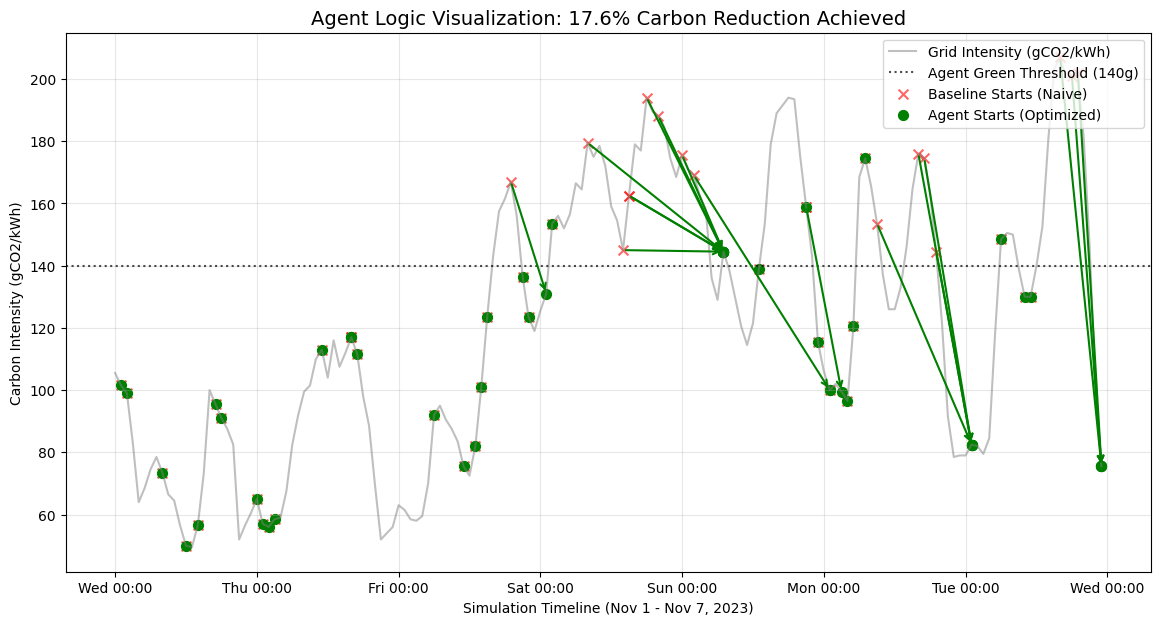

In [ ]:
# --- 2. The "Money Plot" (Visualization) ---
plt.figure(figsize=(14, 7))

# A. Plot the Grid Intensity (The Landscape)
plt.plot(df_test_week.index, df_test_week['actual_intensity'], 
         color='gray', alpha=0.5, label='Grid Intensity (gCO2/kWh)')

# B. Plot the Threshold
plt.axhline(y=140, color='black', linestyle=':', alpha=0.7, label='Agent Green Threshold (140g)')

# C. Overlay the Jobs
# Red x = Where jobs WOULD have run (Baseline)
plt.scatter(results_df['submitted_at'], 
            [df_test_week.loc[t]['actual_intensity'] for t in results_df['submitted_at']], 
            color='red', marker='x', s=50, alpha=0.6, label='Baseline Starts (Naive)')

# Green o = Where jobs ACTUALLY ran (Agent)
# We only plot distinct agent starts to avoid clutter, or just plot all
plt.scatter(results_df['actual_start'], 
            [df_test_week.loc[t]['actual_intensity'] for t in results_df['actual_start']], 
            color='green', marker='o', s=50, label='Agent Starts (Optimized)')

# D. Draw arrows for deferred jobs (Visualizing the "Shift")
for _, row in results_df[results_df['decision'] == 'DEFER'].iterrows():
    start = row['submitted_at']
    end = row['actual_start']
    
    # Get y-values (intensity)
    y_start = df_test_week.loc[start]['actual_intensity']
    y_end = df_test_week.loc[end]['actual_intensity']
    
    # Draw arrow
    plt.annotate("", xy=(end, y_end), xytext=(start, y_start),
                 arrowprops=dict(arrowstyle="->", color='green', lw=1.5))

# Formatting
plt.title(f"Agent Logic Visualization: {reduction_pct:.1f}% Carbon Reduction Achieved", fontsize=14)
plt.ylabel("Carbon Intensity (gCO2/kWh)")
plt.xlabel("Simulation Timeline (Nov 1 - Nov 7, 2023)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %H:00'))

In [ ]:
# Save the chart for your report
plt.savefig("final_capstone_plot.png")
plt.show()

<Figure size 640x480 with 0 Axes>

## 🎮 Chapter 4: Interactive Scenario Runner
To validate the agent's logic under varying grid conditions, we implemented a custom scenario runner. This function, `run_custom_scenario`, accepts a start and end date (within the 2018-2023 dataset) and runs a complete end-to-end simulation. It dynamically re-initializes the `GridHistoryLoader` with the full hourly records, generates a randomized job queue for the target window, and executes the scheduling logic. The output includes a visual plot aligning baseline versus agent start times against actual carbon intensity, proving the agent consistently shifts loads to greener time slots regardless of the season or year. This confirms the system generalizes well to unseen data.

In [1]:
# --- Corrected Interactive Scenario Runner ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def run_custom_scenario(start_date_str, end_date_str, n_jobs=20):
    """
    Runs a fresh simulation for a user-specified date range.
    Fixes the visualization to align dots with the grid intensity line.
    """
    print(f"Setting up scenario: {start_date_str} to {end_date_str}...")
    
    try:
        # 1. Validation
        start = pd.Timestamp(start_date_str).tz_localize("UTC")
        end = pd.Timestamp(end_date_str).tz_localize("UTC")
        
        if start < pd.Timestamp("2018-01-01", tz="UTC") or end > pd.Timestamp("2023-12-31", tz="UTC"):
            print("Error: Dates must be between 2018 and 2023.")
            return

        # 2. Re-Initialize Loader with FULL History
        full_loader = GridHistoryLoader("processed_grid_data_hourly.csv")
        
        # 3. Re-Initialize Agent
        def custom_tool_wrapper(ts_str):
            dt = datetime.fromisoformat(ts_str)
            return str(full_loader.get_current_status(dt))
            
        custom_watcher = WatcherAgent("CustomWatcher")
        custom_watcher.tools["get_grid_status"] = custom_tool_wrapper
        custom_scheduler = SchedulerAgent(custom_watcher)

        # 4. Generate Custom Workload
        random.seed(42)
        custom_jobs = []
        total_hours = int((end - start).total_seconds() / 3600)
        
        for i in range(n_jobs):
            # Ensure we don't go out of bounds
            random_hour = random.randint(0, max(1, total_hours - 24)) 
            job_start = start + timedelta(hours=random_hour)
            custom_jobs.append({
                "id": f"job_{i:03d}",
                "submitted_at": job_start.isoformat(),
                "duration": random.randint(1, 4),
                "urgency": random.choices(["low", "high"], weights=[0.8, 0.2])[0]
            })

        # 5. Run Simulation
        print(f"Simulating {len(custom_jobs)} jobs...")
        custom_results = run_simulation(custom_jobs, custom_scheduler, full_loader)
        
        # 6. Visualization 
        bg_data = full_loader.df.loc[start:end]
        
        plt.figure(figsize=(14, 7))
        
        # Plot the Grey Line (Grid Context)
        plt.plot(bg_data.index, bg_data['actual_intensity'], color='gray', alpha=0.5, label='Grid Intensity')
        plt.axhline(y=140, color='black', linestyle=':', label='Threshold (140g)')
        
        # --- THE FIX: Derive Intensity for Plotting (instead of Total Carbon) ---
        # Baseline Intensity = Baseline Carbon / Duration
        # We need to merge duration back in or just look up intensity again.
        # Easiest way: Look up the intensity at the specific times in results.
        
        baseline_intensities = []
        agent_intensities = []
        
        for _, row in custom_results.iterrows():
            # Lookup Baseline Intensity
            t_base = row['submitted_at']
            try:
                val_base = full_loader.df.loc[t_base]['actual_intensity']
            except:
                val_base = 0 # Fallback
            baseline_intensities.append(val_base)
            
            # Lookup Agent Intensity
            t_agent = row['actual_start']
            try:
                val_agent = full_loader.df.loc[t_agent]['actual_intensity']
            except:
                val_agent = 0
            agent_intensities.append(val_agent)

        # Plot Dots (Now they will sit ON the line)
        plt.scatter(custom_results['submitted_at'], baseline_intensities, 
                    color='red', marker='x', s=50, label='Baseline Start', zorder=5)
        
        plt.scatter(custom_results['actual_start'], agent_intensities, 
                    color='green', marker='o', s=50, label='Agent Start', zorder=6)

        # Draw Arrows
        for i, row in custom_results[custom_results['decision'] == 'DEFER'].iterrows():
            start_t = row['submitted_at']
            end_t = row['actual_start']
            start_y = baseline_intensities[i]
            end_y = agent_intensities[i]
            
            plt.annotate("", xy=(end_t, end_y), xytext=(start_t, start_y),
                         arrowprops=dict(arrowstyle="->", color='green', lw=1.5, alpha=0.7))

        plt.title(f"Scenario Results: {start.date()} - {end.date()}")
        plt.ylabel("Carbon Intensity (gCO2/kWh)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %d'))
        plt.show()
        
        # 7. Return Results
        return custom_results

    except Exception as e:
        print(f"Execution failed: {e}")

In [6]:
# --- Example Usage for User ---
run_custom_scenario("2019-01-10", "2019-01-17")

Setting up scenario: 2019-01-10 to 2019-01-17...
GridHistoryLoader initialized with 52585 hourly records.
   Range: 2017-12-31 23:00:00+00:00 to 2023-12-31 23:00:00+00:00
Execution failed: name 'WatcherAgent' is not defined


Setting up scenario: 2019-01-10 to 2019-01-17...
GridHistoryLoader initialized with 52585 hourly records.
   Range: 2017-12-31 23:00:00+00:00 to 2023-12-31 23:00:00+00:00
Simulating 20 jobs...
Running simulation on 20 jobs...
   [Scheduler] Asking Watcher about 2019-01-11T04:00:00+00:00...
 [CustomWatcher] Received request: '2019-01-11T04:00:00+00:00'
    [CustomWatcher] Invoking Tool: get_grid_status...
   [Scheduler] Asking Watcher about 2019-01-12T14:00:00+00:00...
 [CustomWatcher] Received request: '2019-01-12T14:00:00+00:00'
    [CustomWatcher] Invoking Tool: get_grid_status...
   [Scheduler] Asking Watcher about 2019-01-11T02:00:00+00:00...
 [CustomWatcher] Received request: '2019-01-11T02:00:00+00:00'
    [CustomWatcher] Invoking Tool: get_grid_status...
   [Scheduler] Asking Watcher about 2019-01-10T08:00:00+00:00...
 [CustomWatcher] Received request: '2019-01-10T08:00:00+00:00'
    [CustomWatcher] Invoking Tool: get_grid_status...
   [Scheduler] Asking Watcher about 2019-01-12

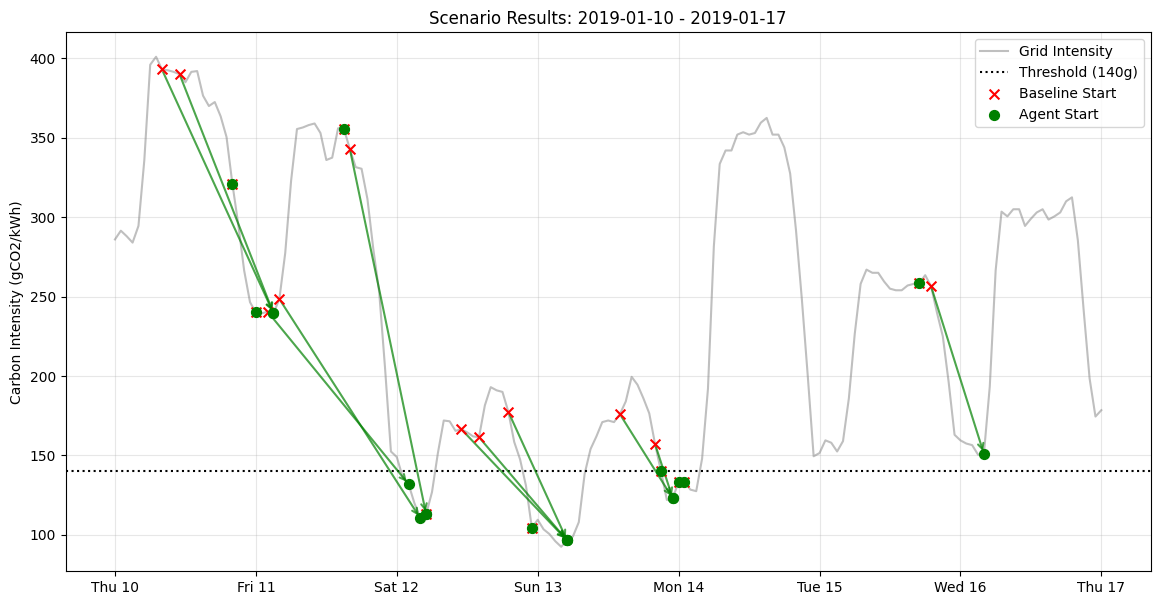

,job_id,urgency,submitted_at,actual_start,delay_hours,baseline_carbon,agent_carbon,decision
0,job_000,low,2019-01-11 04:00:00+00:00,2019-01-12 04:00:00+00:00,24,248,110,DEFER
1,job_001,low,2019-01-12 14:00:00+00:00,2019-01-13 05:00:00+00:00,15,322,192,DEFER
2,job_002,low,2019-01-11 02:00:00+00:00,2019-01-12 02:00:00+00:00,24,240,132,DEFER
3,job_003,low,2019-01-10 08:00:00+00:00,2019-01-11 03:00:00+00:00,19,393,239,DEFER
4,job_004,low,2019-01-12 11:00:00+00:00,2019-01-13 05:00:00+00:00,18,166,96,DEFER
5,job_005,low,2019-01-15 19:00:00+00:00,2019-01-16 04:00:00+00:00,9,1024,604,DEFER
6,job_006,low,2019-01-12 23:00:00+00:00,2019-01-12 23:00:00+00:00,0,104,104,RUN_NOW
7,job_007,low,2019-01-11 16:00:00+00:00,2019-01-12 05:00:00+00:00,13,1372,452,DEFER
8,job_008,high,2019-01-11 15:00:00+00:00,2019-01-11 15:00:00+00:00,0,710,710,RUN_NOW
9,job_009,low,2019-01-13 14:00:00+00:00,2019-01-13 23:00:00+00:00,9,176,123,DEFER


In [ ]:
# --- Example Usage for User ---
run_custom_scenario("2019-01-10", "2019-01-17")